In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Обзор данных

In [2]:
data = pd.read_csv('stud_math.xls')  # Загружаем датасет для дальнейшей работы
display(data.sample(5))
data.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
301,GP,M,17,U,LE3,T,4.0,4.0,other,teacher,home,father,2.0,1.0,0.0,no,no,yes,no,yes,-3.0,yes,yes,no,4.0,1.0,1.0,5.0,0.0,50.0
376,MS,F,20,NaN,GT3,T,4.0,2.0,health,other,course,NaN,2.0,3.0,2.0,no,yes,yes,no,no,-9.0,yes,yes,yes,5.0,4.0,3.0,3.0,4.0,75.0
331,GP,F,17,R,GT3,T,2.0,4.0,at_home,other,course,NaN,1.0,3.0,0.0,no,yes,no,no,yes,-9.0,NaN,yes,yes,4.0,4.0,3.0,5.0,7.0,70.0
318,GP,F,17,R,GT3,T,3.0,4.0,at_home,services,course,NaN,1.0,3.0,0.0,no,yes,NaN,yes,no,-9.0,yes,yes,no,4.0,3.0,4.0,5.0,0.0,50.0
347,GP,M,18,U,GT3,T,4.0,3.0,teacher,other,course,NaN,1.0,3.0,0.0,no,yes,yes,no,yes,-9.0,NaN,yes,yes,NaN,4.0,5.0,5.0,0.0,45.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

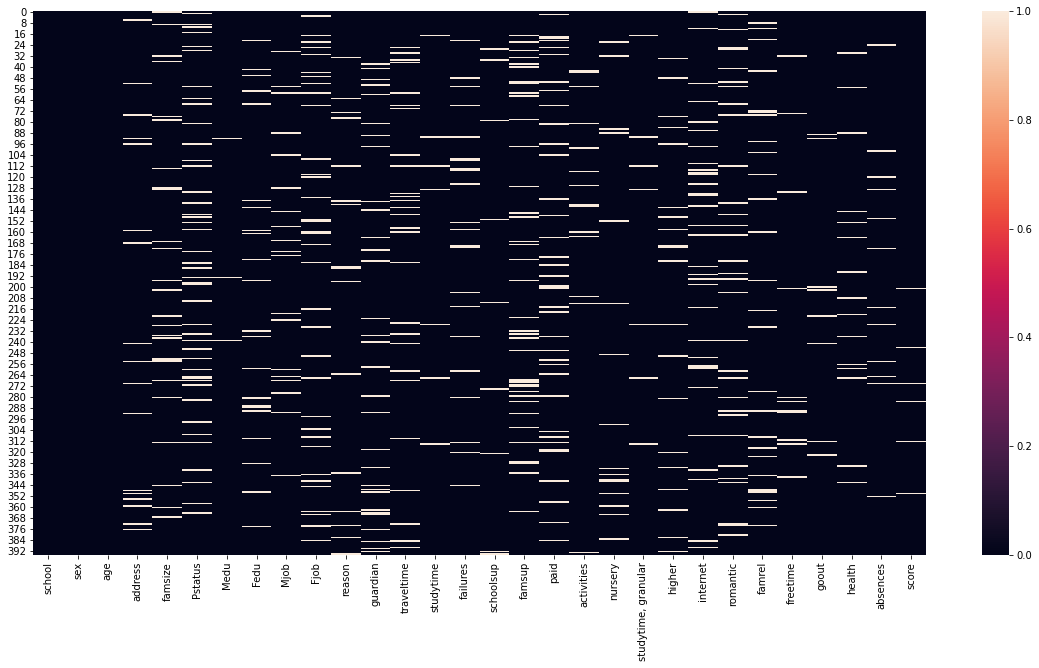

In [3]:
# Тепловая карта "пустых" значений (т.е. Nan). Белые полоски - пропуски в данных
# Наша первостепенная цель - избавиться от этих пустых значений
ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(data.isnull())

<AxesSubplot:>

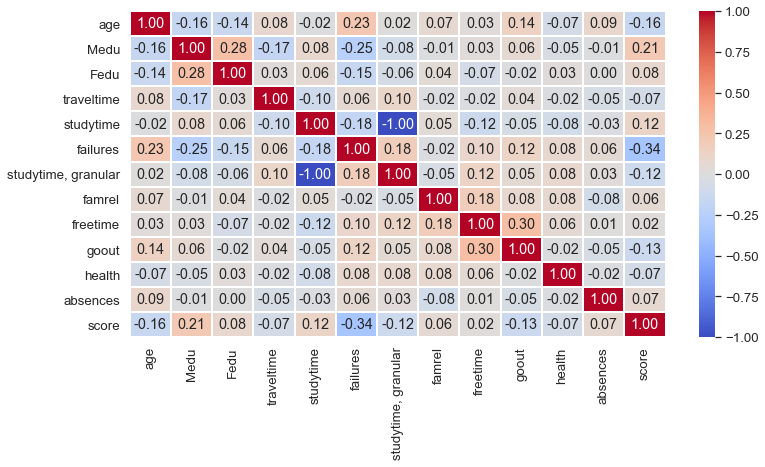

In [4]:
# Посмотрим на матрицу корреляций признаков
sns.set(font_scale=1.2) 
plt.subplots(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")

Видно, что коэфф. корреляция между "studytime, granular" и  "studytime" равен -1, что говорит нам о том, что эти данные по сути показывают одну и ту же информацию. Удалим один из этих столбцов

In [5]:
# Удаляем этот, так как совсем не понятно, что он обозначает
data = data.drop('studytime, granular', 1)

In [6]:
# Проверяем, где есть пропуски и дубликаты 
print("Дубликатов найдено:", data.duplicated(keep=False).sum())
print("Пропусков найдено:", data.isnull().sum().sum())

Дубликатов найдено: 0
Пропусков найдено: 558


395 строк. Видно, в каких столбцах есть пустые значения и сколько их. 
С помощью функции чуть позже заменим пропуски в некоторых столбцах (где тип данных - объект) и подробнее изучим каждый столбец

# Дополнительные функции для удобства дальнейшей работы

In [7]:
# Создадим список, куда будем добавлять имена признаков, для дальнейшей работы при построении модели
features_for_the_model = []  

def no_info(column):
    '''Функция заменяет пропуски в выбранном столбце на "no_info"'''
    data[column] = data[column].fillna(value='no_info')

    
# Применим эту функцию для некоторых категориальных признаков
no_info(['address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
         'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])


def noinfo_to_other(column):
    '''Функция для замены в столбце no_info на other'''
    data[column] = data[column].apply(lambda x: 'other' if x == 'no_info' else x)

In [8]:
def median_data(column):
    '''Функция заменяет пропуски на медианные данные в числовом столбце'''
    data[column].fillna(value=data[column].median(), inplace=True)


def mode_data(column):
    '''Функция заменяет пропуски на моду в числовом столбце'''
    data[column].fillna(value=data[column].mode()[0], inplace=True)

    
def boxplot_for_cat(column, feature, figsize=(16, 3)):
    """Функция для создания boxplot для категориальных признаков"""
    sns.set(font_scale=1.4)
    plt.subplots(figsize=figsize)
    plt.xticks(ticks=range(0, 101, 5))
    plt.title('Распределение оценок в зависимости от ' + feature)
    sns.boxplot(y=column, x=data.score, color='royalblue')
    plt.xlabel('Количество баллов')

    
def histplot_for_cat(column, bins='auto', figsize=(3, 3)):
    """Функция для создания гистограммы для категориальных признаков"""
    sns.set(font_scale=1.25)
    plt.figure(figsize=figsize)
    plt.ylabel('Количество учеников')
    sns.histplot(column, color='royalblue', bins=bins)
    
    
def get_boxplot(column):
    """Функция для создания boxplot"""
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.boxplot(x=column,
                y='score',
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column):
    """Функция для поиска статистически значимых различий для колонок"""
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'],
                     data.loc[data.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    
    
def IQR_for_column(column):
    """Функция возвращает квартили, выводит границы для выбросов, согласно IQR и считает сколько выбросов (в том числе в %)"""
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    min_out = perc25 - 1.5*IQR
    max_out = perc75 + 1.5*IQR
    anomaly = len(data[data[column] > max_out]) + len(data[data[column] < min_out])
    print(
    '25-й перцентиль: {} |'.format(perc25),
    '75-й перцентиль: {} |'.format(perc75),
    "IQR: {} | ".format(IQR),
    "Границы выбросов: [{}, {}].".format(min_out, max_out))
    print("Выбросов, согласно IQR: {} | {:2.2%}".format(anomaly, anomaly/len(data)))

# Изучаем данные в каждом столбце отдельно

## score - наша целевая переменная

25-й перцентиль: 40.0 | 75-й перцентиль: 70.0 | IQR: 30.0 |  Границы выбросов: [-5.0, 115.0].
Выбросов, согласно IQR: 0 | 0.00%
Всего у 6 учеников не известно оценки


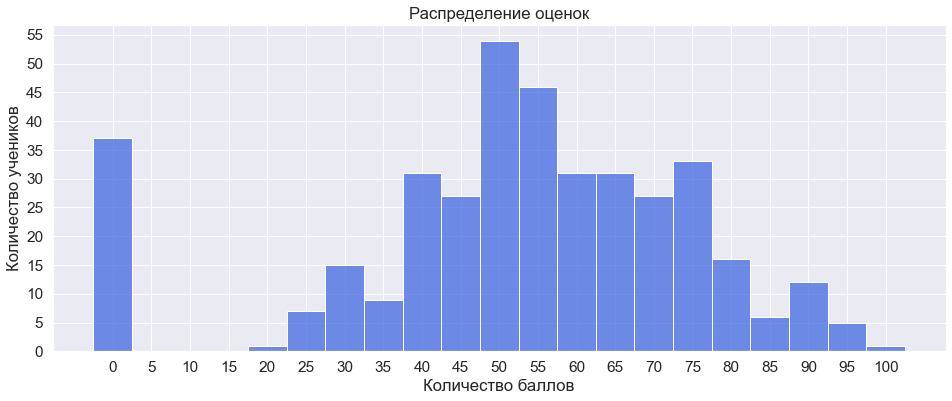

In [9]:
IQR_for_column('score')
print('Всего у {} учеников не известно оценки'.format(data.score.isnull().sum()))

# Посмотрим на распределение оценок
sns.set(font_scale=1.4)
plt.figure(figsize=(16,6))
plt.yticks(ticks=range(0,60,5))
plt.xticks(ticks=range(0,105,5))
plt.title('Распределение оценок')
plt.xlabel('Количество баллов')
plt.ylabel('Количество учеников')
sns.histplot(data.score, discrete=True, shrink=5, color='royalblue')
plt.show()

У 37-ми человек оценка "0" и они похожи на выбросы (выбиваются из картины нормального распредения), хоть по IQR нельзя назвать выбросами. Но удалять их нельзя, посколько не известно, что это значит (и правда 0 баллов, неявка, списывание или т.п.).

Шесть значений отсутствуют. Эти оценки - самые важные данные, поэтому можно смело удалять такие строчки с Nan

In [10]:
# Удаляем строки, в который в столбце score нет информации
data = data.dropna(subset=['score'])

## school

Всего у 0 учеников не известно школы


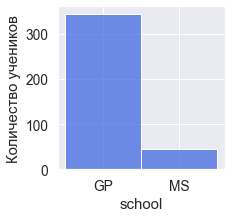

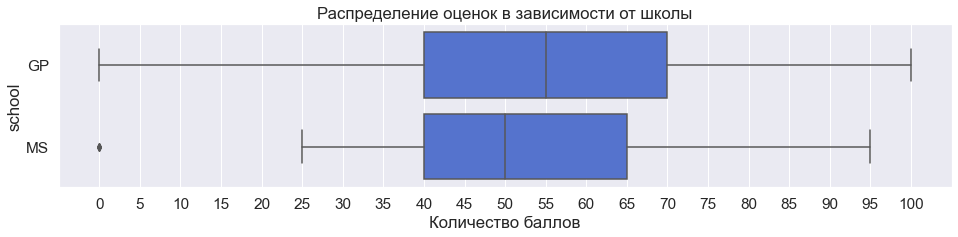

In [11]:
histplot_for_cat(data.school)
print('Всего у {} учеников не известно школы'.format(data.school.isnull().sum()))
# Посмотрим на распределение оценок от значений признака
boxplot_for_cat(data.school, 'школы')

Пропущенные значения и ошибки не наблюдаются. Явной зависимости оценок от школы не заметно.

## sex

Пропущенные значения и ошибки не наблюдаются

Всего у 0 учеников не известно пола


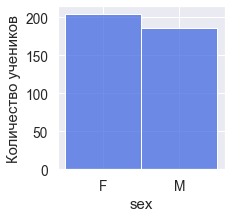

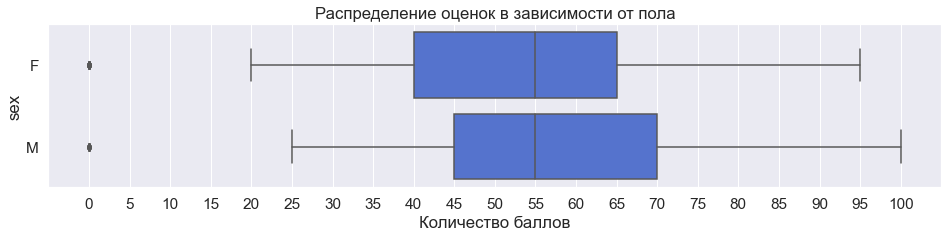

In [12]:
histplot_for_cat(data.sex)
print('Всего у {} учеников не известно пола'.format(data.sex.isnull().sum()))
boxplot_for_cat(data.sex, 'пола')

Пропущеных значений и ошибок нет. Глядя на boxplot можно сделать, что мальчики чуть лучше сдают экзамен, сильно сильно пол не зависит на оценку

## age

16    103
17     98
15     82
18     80
19     21
20      3
22      1
21      1
Name: age, dtype: int64

Всего у 0 учеников не известен возраст
25-й перцентиль: 16.0 | 75-й перцентиль: 18.0 | IQR: 2.0 |  Границы выбросов: [13.0, 21.0].
Выбросов, согласно IQR: 1 | 0.26%


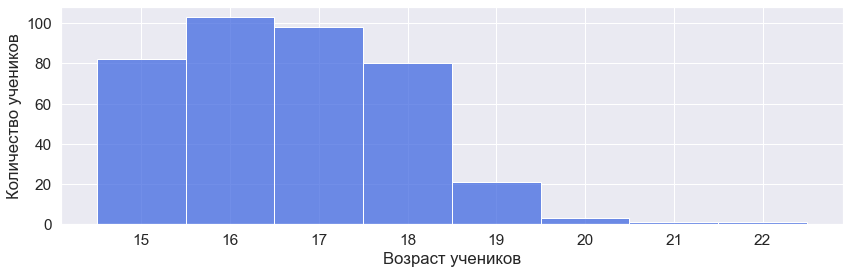

In [13]:
# Проверяем, если ли пропущенные значения и ошибки в столбце возраста
display(data.age.value_counts())
print('Всего у {} учеников не известен возраст'.format(data.age.isnull().sum()))
IQR_for_column('age')

# Посмотрим на распределение по возрасту
sns.set(font_scale=1.4)
plt.figure(figsize=(14,4))
plt.xlabel('Возраст учеников')
plt.ylabel('Количество учеников')
sns.histplot(data.age, discrete=True, color='royalblue')
plt.show()

Пропущенные значения и ошибки не наблюдаются

Есть всего 5 детей, чей возраст больше 19. На данный момент не вижу причины считать их выбросами и  не учитывать при дальнейшем построении модели (хоть и IQR показывается, что 22 - это выброс). И первоначальная цель проекта - 'отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет'

## address

Всего у 15 учеников не известно адреса


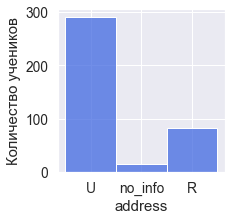

In [14]:
histplot_for_cat(data.address)
print('Всего у {} учеников не известно адреса'.format(len(data[data.address == 'no_info'])))

Можно предположить, что те, кто живут за городом тратят времени на дорогу в школу больше часа. 

In [15]:
# Смотрим на медиану данных о времени поездки в школу
data.traveltime.median()

1.0

Медиана равна 1, что очень хорошо, поскольку признак по факту категориальный. Заменим пустые значения в столце времени пути на медиану и посмотрим значение для учеников, для которых отсутствует информация о типе адреса

In [16]:
median_data('traveltime')
data[data['address'] == 'no_info'].traveltime

6      1.0
52     2.0
75     1.0
92     1.0
96     2.0
159    1.0
168    1.0
241    1.0
254    1.0
292    1.0
348    1.0
354    2.0
359    2.0
372    1.0
376    2.0
Name: traveltime, dtype: float64

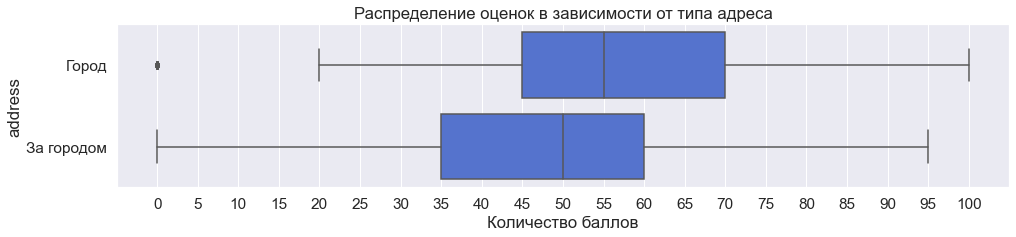

In [17]:
data.loc[data['address'] == 'no_info', 'address'] = 'U'
data.address = data.address.apply(
    lambda x: 'Город' if x == 'U' else 'За городом')
boxplot_for_cat(data.address, 'типа адреса')

Можно заметить, что те кто живут за городом имеют меньше баллов. Поэтому внесём этот признак в список признаков для дальшейшей работы при построении модели.

In [18]:
features_for_the_model.append('address')

## famsize

Всего у 27 учеников не известен размер семьи


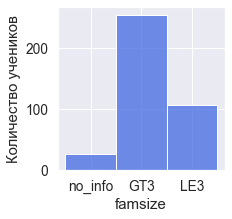

In [19]:
histplot_for_cat(data.famsize)
print('Всего у {} учеников не известен размер семьи'.format(len(data[data.famsize == 'no_info'])))

Заменим эти значения на моду (т.е. GT3), это чуть меньше отразится на процентную разницу между данными о размере семьи. И переименуем значения для лучшего понимания

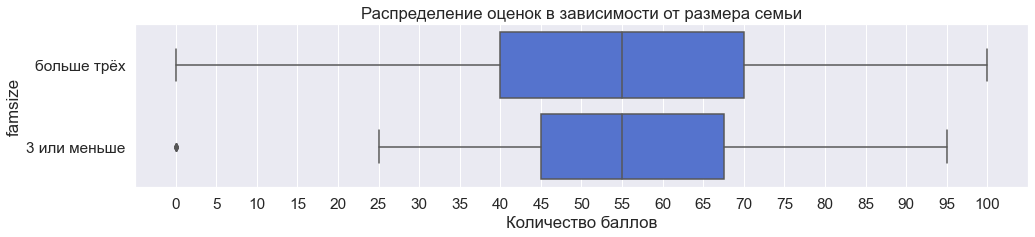

In [20]:
data.loc[data['famsize'] == 'no_info', 'famsize'] = 'GT3'
data.famsize = data.famsize.apply(
    lambda x: "3 или меньше" if x == 'LE3' else 'больше трёх')
boxplot_for_cat(data.famsize, 'размера семьи')

Каких либо выводов о зависимости оценок от размера семьи нельзя сделать

## Pstatus

Всего у 45 учеников не известен статус жительства родителей


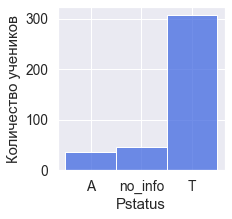

In [21]:
histplot_for_cat(data.Pstatus)
print('Всего у {} учеников не известен статус жительства родителей'.format(
    len(data[data.Pstatus == 'no_info'])))

Отсутсвуют данные о статусе совместного проживания родителей 45-и учеников (это 11,4% от общего количества). На мой взгляд не корректно это данные относить к совместному проживанию или отдельному (будет большая разница в конечном результате при дальнейшем исследовании этих двух вариантов)

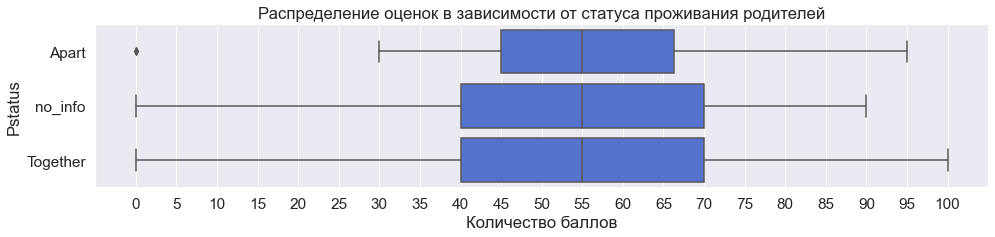

In [22]:
data.Pstatus = data.Pstatus.apply(
    lambda x: 'Together' if x == 'T' else 'Apart' if x == 'A' else x)
boxplot_for_cat(data.Pstatus, 'статуса проживания родителей')

Каких либо выводов о зависимости оценок от проживания родителей нельзя сделать

## Medu

Всего у 3 учеников не известно образование матери


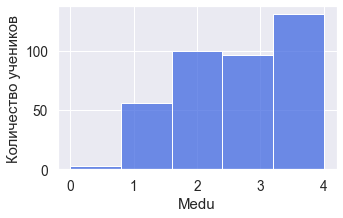

In [23]:
histplot_for_cat(data.Medu, bins=5, figsize=(5, 3))
print('Всего у {} учеников не известно образование матери'.format(data.Medu.isnull().sum()))

Заменим эти пустые данные на моду этого столбца и переименуем данные для лучшего восприятия. 

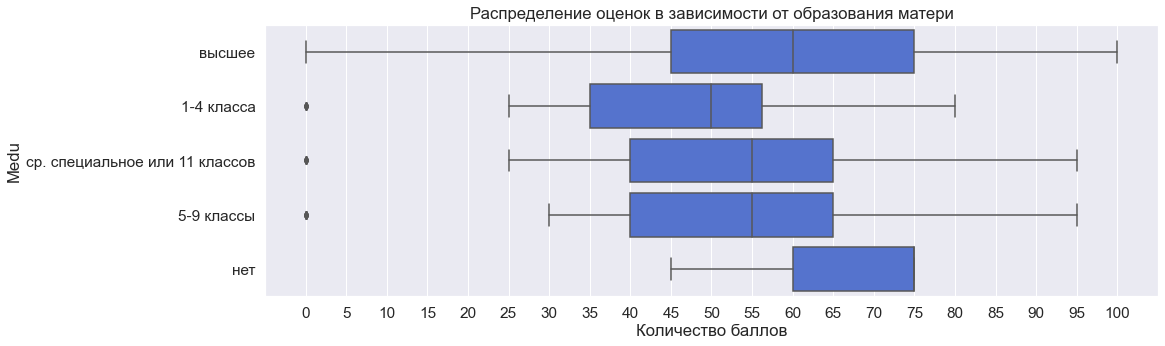

In [24]:
mode_data('Medu')
data.Medu = data.Medu.apply(lambda x: 'нет' if x == 0 else
                            '1-4 класса' if x == 1 else
                            '5-9 классы' if x == 2 else
                            'ср. специальное или 11 классов' if x == 3 else
                            'высшее')
boxplot_for_cat(data.Medu, 'образования матери', figsize=(16, 5))

## Fedu 

In [25]:
display(data.Fedu.value_counts())
print('Всего у {} учеников не известно образование отца'.format(data.Fedu.isnull().sum()))

2.0     105
3.0      94
4.0      88
1.0      75
0.0       2
40.0      1
Name: Fedu, dtype: int64

Всего у 24 учеников не известно образование отца


In [26]:
# Одна явная ошибка (значение 40). Посмотрим на данные об объекте внимательнее
data[data['Fedu'] > 4]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,Город,больше трёх,no_info,5-9 классы,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


У этого же ученика отсутствует данные о статусе совместного жилья родителей, все остальные столбцы в порядке. Будем считать, что случилась опечатка, и вместо "4" напечатали "40". Изменим данное значение

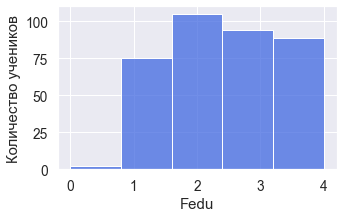

In [27]:
data.loc[data['Fedu'] == 40, 'Fedu'] = 4
histplot_for_cat(data.Fedu, bins=5, figsize=(5, 3))

Посмотрим распределение оценок в зависимости от образования отца с помощью boxplot

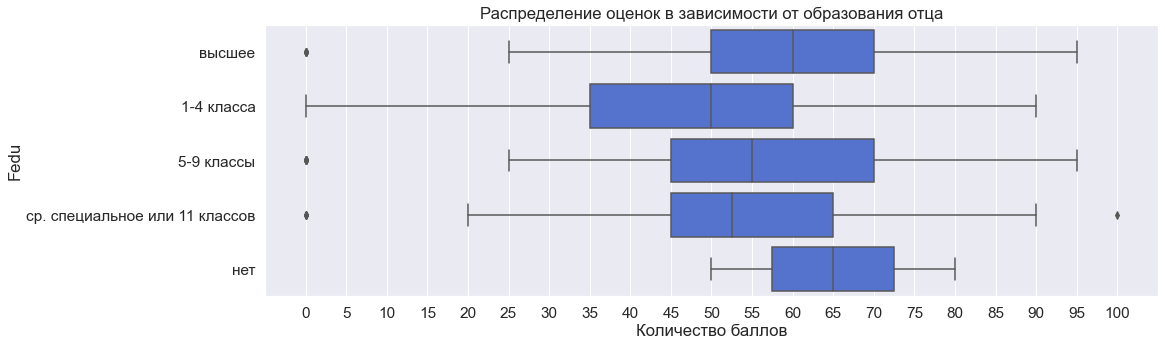

In [28]:
data.Fedu = data.Fedu.apply(lambda x: 'нет' if x == 0 else
                            '1-4 класса' if x == 1 else
                            '5-9 классы' if x == 2 else
                            'ср. специальное или 11 классов' if x == 3 else
                            'высшее' if x == 4 else x)
boxplot_for_cat(data.Fedu, 'образования отца', figsize=(16, 5))

Видно, что есть различие в оценках в разных случаях. Поэтому заполнять пустые строчки на мой взгляд не самая удачная идея. Добавим их в отдельную группу "no_info" и переименнуем остальные варианты для большей наглядности. Добавим данный признак в список признаков для последующей работы

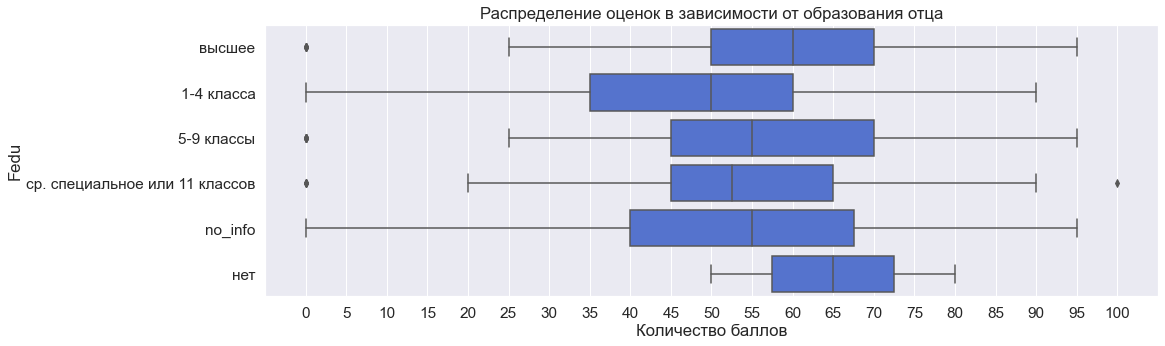

In [29]:
no_info("Fedu")
features_for_the_model.append('Fedu')
boxplot_for_cat(data.Fedu, 'образования отца', figsize=(16, 5))

## Mjob

Всего у 19 учеников не известно о работе матери


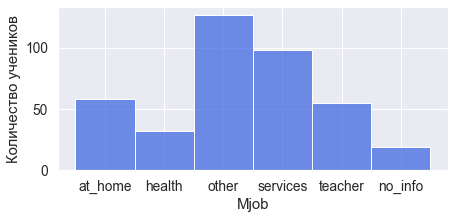

In [30]:
histplot_for_cat(data.Mjob, bins=6, figsize=(7, 3))
print('Всего у {} учеников не известно о работе матери'.format(len(data[data.Mjob == 'no_info'])))

Отнесём отсутствующие данные в категорию "другая" работа

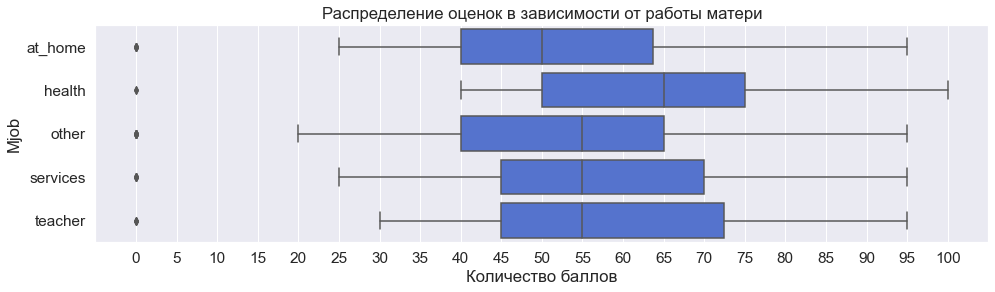

In [31]:
data.Mjob = data.Mjob.apply(lambda x: 'other' if x == 'no_info' else x)
boxplot_for_cat(data.Mjob, 'работы матери', figsize=(16, 4))

## Fjob

Всего у 36 учеников не известно о работе отца


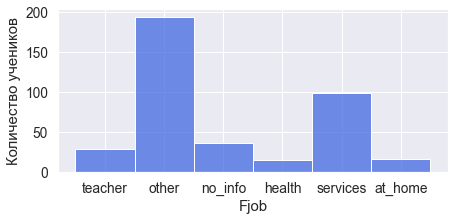

In [32]:
histplot_for_cat(data.Fjob, bins=6, figsize=(7, 3))
print('Всего у {} учеников не известно о работе отца'.format(len(data[data.Fjob == 'no_info'])))

Отсутсвуют 36 данных о работе отца. Отнесём данные в "другие"

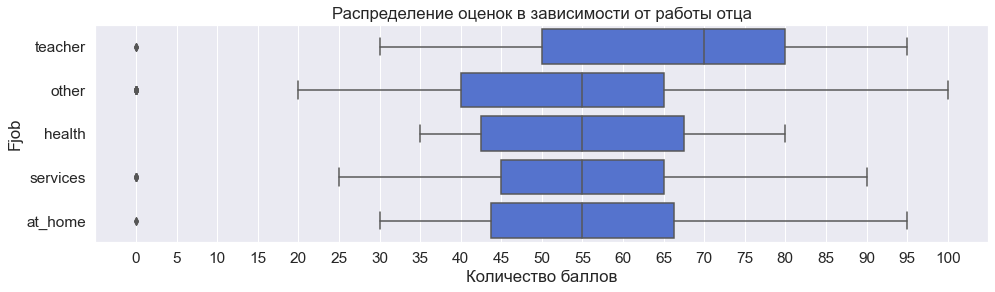

In [33]:
data.Fjob = data.Fjob.apply(lambda x: 'other' if x == 'no_info' else x)
boxplot_for_cat(data.Fjob, 'работы отца', figsize=(16, 4))

## reason

Всего у 17 учеников не известно о причине выбора школы


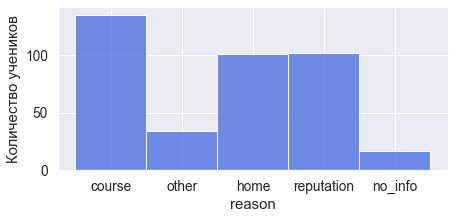

In [34]:
histplot_for_cat(data.reason, bins=6, figsize=(7, 3))
print('Всего у {} учеников не известно о причине выбора школы'.format(len(data[data.reason == 'no_info'])))

Отсутствуют 17 данных. Так же отнесём их в категорию "другие".

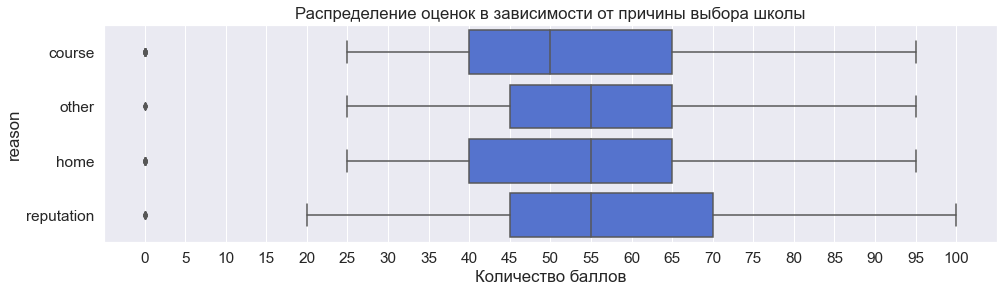

In [35]:
data.reason = data.reason.apply(lambda x: 'other' if x == 'no_info' else x)
boxplot_for_cat(data.reason, 'причины выбора школы', figsize=(16, 4))

## guardian 

Всего у 31 учеников не известно о том, кто является опекуном


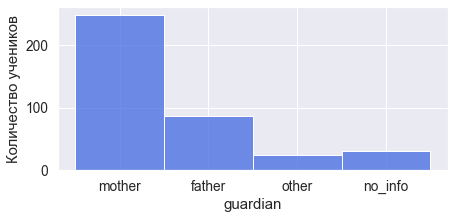

In [36]:
histplot_for_cat(data.guardian, bins=6, figsize=(7, 3))
print('Всего у {} учеников не известно о том, кто является опекуном'.format(
    len(data[data.guardian == 'no_info'])))

Нет информации о 7.8% опекунах учеников  Это большой процент, в группе "другие" всего 7.1%, поэтому оставлю эти данные в группе "без информации"

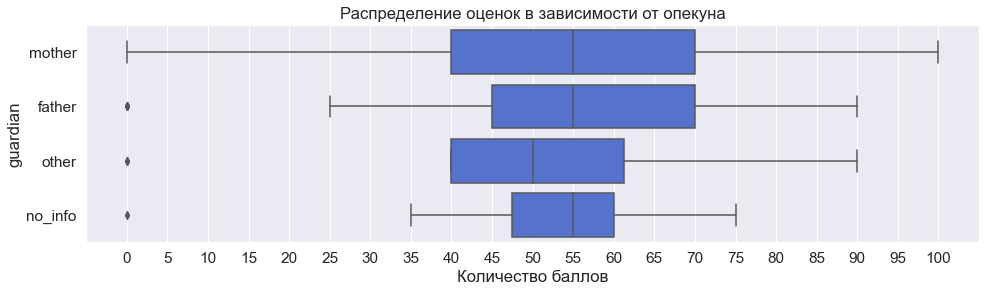

In [37]:
boxplot_for_cat(data.guardian, 'опекуна', figsize=(16, 4))

## traveltime 

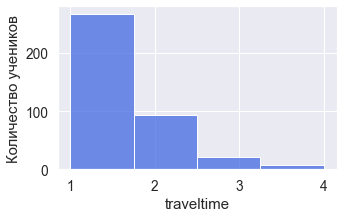

In [38]:
histplot_for_cat(data.traveltime, bins=4, figsize=(5, 3))

Выше уже заменил пустые данные на медиану этого столбца. Дополнительно переименую данные, для более комфортного восприятия

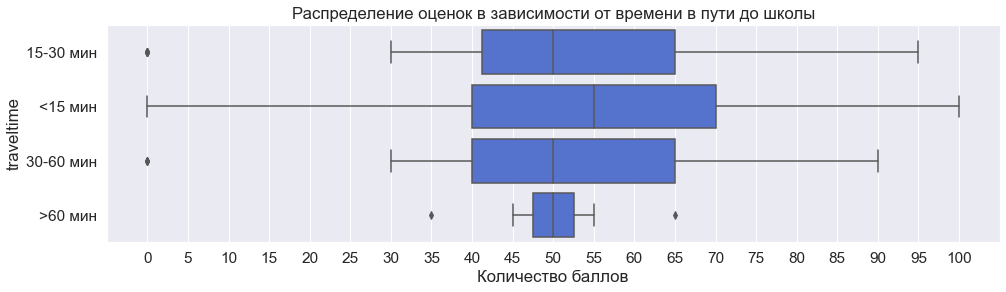

In [39]:
data.traveltime = data.traveltime.apply(lambda x: '<15 мин' if x == 1 else
                                        '15-30 мин' if x == 2 else
                                        '30-60 мин' if x == 3 else
                                        '>60 мин')
boxplot_for_cat(data.traveltime, 'времени в пути до школы', figsize=(16, 4))

## studytime 

In [ ]:
data.studytime.value_counts()

Отсутствует информация о времени на учёбу для 7-ми учеников. Проверим медиану в этом столбце, и если это целое число - заменим эти пропуски медианой и дополнительно переименую для комфортного восприятия

In [ ]:
data.studytime.median()

In [ ]:
median_data('studytime')
data.studytime = data.studytime.apply(lambda x: '<2 часов' if x == 1 else
                                      '2-2.5 часов' if x == 2 else
                                      '5-10 часов' if x == 3 else
                                      '>10 часов')
data.studytime.value_counts().plot(kind='pie', autopct='%1.1f%%', radius=1.2)

## failures

In [ ]:
data.failures.value_counts()

Отсутствует 22 данных о "количестве внеучебных неудач". Заменим эти пропуски модой (0.0, которая составляет более 75%).

In [ ]:
mode_data('failures')
data.failures.value_counts().plot(kind='pie', autopct='%1.1f%%', radius=1.2)

## schoolsup и famsup 

In [ ]:
display(data.schoolsup.value_counts())
data.famsup.value_counts()

В первом случае отсутствуют данные о 9-ти учениках, во втором - у 39. Объединим данные из этих столбиков в один, в котором будет информация об общей образовательной поддержки (не важно, семейной или другой дополнительной) 

In [ ]:
# Создадим новый столбец просуммировав два столбца
data['support'] = data['schoolsup'] + data['famsup']

data.support = data.support.apply(lambda x: 'yes' if 'yes' in x              # Изменяем в нём данные на "yes", "no" или "no_info"
                                  else 'no_info' if x == 'no_infono_info'
                                  else 'no')

data.drop('schoolsup', axis=1, inplace=True)  # Удаляем столбец schoolsup
data.drop('famsup', axis=1, inplace=True)     # Удаляем столбец famsup

In [ ]:
data.support.value_counts().plot(kind='pie', autopct='%1.1f%%', radius=1.2)

## paid, activities, nursery higher, internet и romantic

In [ ]:
display(data.paid.value_counts())
display(data.activities.value_counts())
display(data.nursery.value_counts())
display(data.higher.value_counts())
display(data.internet.value_counts())
data.romantic.value_counts()

Во всех этих столбцах есть всего два точных варианта (yes или no) и те ученики, для которых данные не известны (no_info).
Лучше оставлю этот третий вариант, чтобы сильно не менялось соотношение между yes и no, что исказит результаты корреляции с score. (В принципе можно было в столбце nursery заменить no_info на моду (yes), но мною решено, что раз остальные не трогаю, то и этот не трогать будет правильнее)

## famrel

In [ ]:
data.famrel.value_counts()

Отсутствует 27 данных, и одно не верное (-1). Можно предположить, что это опечатка, поэтому заменим на 1.
А пропуски заменим модой.

In [ ]:
data.loc[(data[data['famrel'] == -1].index), 'famrel'] = 1
mode_data('famrel')
data.famrel.value_counts().plot(kind='pie', autopct='%1.1f%%', radius=1.2)

## freetime

In [ ]:
display(data.freetime.value_counts())
data.freetime.describe()

Отсутствует 9 данных. Заменим пропуски на медианные данные (которые так же являются модой)

In [ ]:
median_data('freetime')
data.freetime.value_counts().plot(kind='pie', autopct='%1.1f%%', radius=1.2)

## goout

In [ ]:
display(data.goout.value_counts())

Отсутствует 7 данных. Посмотрим внимательно на данные связанные со временем об этих учениках.

In [ ]:
data[data['goout'].isnull()][['traveltime', 'studytime', 'freetime']]

Все они тратят мало времени на дорогу до учёбы. На основе двух других колонок сделаем предположение о их времени с друзьями и заполним пропуски. Разумеется это время не может превышать свободное время

In [ ]:
data.loc[89, 'goout'] = 1.0
data.loc[92, 'goout'] = 3.0
data.loc[200, 'goout'] = 3.0
data.loc[202, 'goout'] = 4.0
data.loc[221, 'goout'] = 2.0
data.loc[241, 'goout'] = 3.0
data.loc[322, 'goout'] = 2.0

In [ ]:
data.goout.value_counts().plot(kind='pie', autopct='%1.1f%%', radius=1.2)

## health

In [ ]:
data.health.value_counts()

Отсутсвуют 15 значений. На мой взгляд заполнять пропуски модой или медианой тут не лучший вариант, посколько точно нарушится соотношение в результате, так как разница между количеством разных вариантов не существенная. Поэтому в пропуски добавим в отдельную группу "no_info".

In [ ]:
no_info('health')
data.health.value_counts().plot(kind='pie', autopct='%1.1f%%', radius=1.2)

## absences

In [ ]:
display(data.absences.value_counts())
data.absences.value_counts().sum()

In [ ]:
data.boxplot(column = 'absences', fontsize = 13, figsize = (4,6))

Отсутствует 11 значений. Судя по построенному boxplot есть выбросы, но чисто теоретически можем быть столько много пропусков в ученика, поэтому эти данные нельзя удалять. Посмотрим внимательно на строчки, в которых есть пропуски в этой колонке

In [ ]:
data[data['absences'].isnull()]

На первый взгяд никакой зависимости от других колонок придумать нельзя и объяснить причину пропуска в данных очень трудно. Поэтому просто заменим  Nan на медиану

In [ ]:
median_data('absences')

# Перепроверка и выбор данных для последующего построения модели

In [ ]:
# Тепловая карта "пустых" значений (т.е. Nan). Проверяем, остались ли пропуски (белые черточки)
ax = plt.subplots(figsize=(13, 6))
ax = sns.heatmap(data.isnull(), vmax=1)

In [ ]:
data.corr()  # Ещё раз смотрим корреляцию, после того, как избавились от пропусков

Видим, что столбов с одной и той же информацией нет, разные колонки коррелируются по разному. Для дальнейшей модели будем использовать все эти колонки (age, failures, famrel, freetime, goout, absences и score, разумеется). 

Построим boxplot для всех остальных колонок (по оси y - score).

In [ ]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
            'studytime', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'health', 'support']:
    get_boxplot(col)

Глядя на boxplot-ы, можно оставить колонки adress, Medu, Fedu, Mjob, Fjob, studytime, higher, romantic и health. Остальные визуально мало чем отличаются (т.е. мало как влияют на score). 

С помощью теста Стьюдента выясним для каких колонок могут быть найдены статистически значимые различия

In [ ]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian',
            'traveltime', 'studytime', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'support']:
    get_stat_dif(col)

# Выводы

Для дальнейшей работы по построению модели необходимо использовать все числовые колонки (age, failures, famrel,	freetime, goout, absences). Из номинативных переменных обязательно необходимо использовать те колонки, которые прошли тест Стьюдента.

В итоге данные для модели: 

In [ ]:
data_for_model = data.loc[:, ['age', 'failures', 'famrel', 'freetime', 'goout', 'absences', 'address', 'Medu', 'Mjob',
                              'higher', 'romantic', 'score']]
data_for_model.head()

коротые могут быть дополненны колонками Fedu, Fjob, studytime и health